In [15]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
openai.api_key = "sk-"
openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
from data.serialize import SerializerSettings

from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define models ##

In [54]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

# arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    # 'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    # 'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    # 'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    # 'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    # 'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

In [13]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'

data = datasets[ds_name]

In [4]:
train, test= data

In [6]:
data

(Month
 1949-01-01    112.0
 1949-02-01    118.0
 1949-03-01    132.0
 1949-04-01    129.0
 1949-05-01    121.0
               ...  
 1958-03-01    362.0
 1958-04-01    348.0
 1958-05-01    363.0
 1958-06-01    435.0
 1958-07-01    491.0
 Freq: MS, Name: #Passengers, Length: 115, dtype: float64,
 Month
 1958-08-01    505.0
 1958-09-01    404.0
 1958-10-01    359.0
 1958-11-01    310.0
 1958-12-01    337.0
 1959-01-01    360.0
 1959-02-01    342.0
 1959-03-01    406.0
 1959-04-01    396.0
 1959-05-01    420.0
 1959-06-01    472.0
 1959-07-01    548.0
 1959-08-01    559.0
 1959-09-01    463.0
 1959-10-01    407.0
 1959-11-01    362.0
 1959-12-01    405.0
 1960-01-01    417.0
 1960-02-01    391.0
 1960-03-01    419.0
 1960-04-01    461.0
 1960-05-01    472.0
 1960-06-01    535.0
 1960-07-01    622.0
 1960-08-01    606.0
 1960-09-01    508.0
 1960-10-01    461.0
 1960-11-01    390.0
 1960-12-01    432.0
 Freq: MS, Name: #Passengers, dtype: float64)

In [7]:
train, test= data

In [8]:
len(test)

29

In [9]:
train.head(5)

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Freq: MS, Name: #Passengers, dtype: float64

In [3]:
df= pd.read_excel(r"/workspaces/llmtime/train_dataframes.xlsx")
type(df)

pandas.core.frame.DataFrame

In [4]:
df_trim=df.iloc[:, [0, -1]]
df_trim.head(5)

,datetime,DEMAND
0,2015-01-31 01:00:00,954.2018
1,2015-01-31 02:00:00,913.8660
2,2015-01-31 03:00:00,903.3637
3,2015-01-31 04:00:00,889.0806
4,2015-01-31 05:00:00,910.1472


In [28]:
df_train= df_trim[:150]
df_train.tail(3)

,datetime,DEMAND
147,2015-02-06 04:00:00,887.1948
148,2015-02-06 05:00:00,894.5465
149,2015-02-06 06:00:00,939.4745


In [69]:
df_test=df_trim[150:350]
print(df_test.head(3))
print(df_test.tail(3))

               datetime     DEMAND
150 2015-02-06 07:00:00  1029.9243
151 2015-02-06 08:00:00  1192.5079
152 2015-02-06 09:00:00  1295.6597
               datetime     DEMAND
347 2015-02-14 12:00:00  1112.4993
348 2015-02-14 13:00:00  1091.9190
349 2015-02-14 14:00:00  1074.3496


In [12]:
# from sklearn.model_selection import train_test_split

In [13]:
# train_data, test_data = train_test_split(df_trim, test_size=0.3, random_state=42)

In [14]:
# train_data= train_data[:150]
# test_data= test_data[:30]

In [62]:
temp = dict(zip(df_train.iloc[:, 0], df_train.iloc[:, 1]))

df = pd.DataFrame(temp.values(), index=temp.keys())

my_series_train = df.squeeze()

print(my_series_train)
print(type(my_series_train))
print(len(my_series_train))
sorted_train=my_series_train.sort_index()

2015-01-31 01:00:00    954.2018
2015-01-31 02:00:00    913.8660
2015-01-31 03:00:00    903.3637
2015-01-31 04:00:00    889.0806
2015-01-31 05:00:00    910.1472
                         ...   
2015-02-06 02:00:00    919.9696
2015-02-06 03:00:00    900.6830
2015-02-06 04:00:00    887.1948
2015-02-06 05:00:00    894.5465
2015-02-06 06:00:00    939.4745
Name: 0, Length: 150, dtype: float64
<class 'pandas.core.series.Series'>
150


In [70]:
temp2 = dict(zip(df_test.iloc[:, 0], df_test.iloc[:, 1]))

df = pd.DataFrame(temp2.values(), index=temp2.keys())

my_series_test = df.squeeze()

print(my_series_test)
print(type(my_series_test))
print(len(my_series_test))
sorted_test=my_series_test.sort_index()

2015-02-06 07:00:00    1029.9243
2015-02-06 08:00:00    1192.5079
2015-02-06 09:00:00    1295.6597
2015-02-06 10:00:00    1362.0753
2015-02-06 11:00:00    1393.1365
                         ...    
2015-02-14 10:00:00    1104.5938
2015-02-14 11:00:00    1128.3579
2015-02-14 12:00:00    1112.4993
2015-02-14 13:00:00    1091.9190
2015-02-14 14:00:00    1074.3496
Name: 0, Length: 200, dtype: float64
<class 'pandas.core.series.Series'>
200


## Running LLMTime and Visualizing Results ##

In [55]:
model_names

['LLMTime GPT-3.5']

In [71]:
# datasets = get_datasets()
# ds_name = 'AirPassengersDataset'

# data = datasets[ds_name]
# train, test = data # or change to your own data
out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(sorted_train, sorted_test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    # print(out['LLMTime GPT-4'])
    # plot_preds(train, test, pred_dict, model, show_samples=True)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:23<00:00, 23.44s/it]


In [65]:
out['LLMTime GPT-3.5']

{'samples':    2015-02-06 07:00:00  2015-02-06 08:00:00  2015-02-06 09:00:00  \
 0           888.721011           914.670150           894.580494   
 1           926.389116           917.181357           908.810667   
 2           927.226185           925.552047           875.327907   
 3           928.063254           923.877909           918.855495   
 4           916.344288           896.254632           888.721011   
 5           904.625322           915.507219           877.002045   
 6           901.277046           910.484805           911.321874   
 7           923.877909           907.136529           895.417563   
 8           986.658083          1023.489119          1025.163257   
 9           841.008079           856.912390           843.519286   
 
    2015-02-06 10:00:00  2015-02-06 11:00:00  2015-02-06 12:00:00  \
 0           875.327907           853.564114           837.659803   
 1           886.209804           887.883942           938.108082   
 2           858.5865

In [66]:
print(len(out['LLMTime GPT-3.5']['samples']))

10


In [46]:
gpt_4_predictions=out['LLMTime GPT-4']['samples']
gpt_3_5_predictions= out['LLMTime GPT-3.5']['samples']

In [53]:
gpt_3_5_predictions

,2015-02-06 07:00:00,2015-02-06 08:00:00,2015-02-06 09:00:00,2015-02-06 10:00:00,2015-02-06 11:00:00,2015-02-06 12:00:00,2015-02-06 13:00:00,2015-02-06 14:00:00,2015-02-06 15:00:00,2015-02-06 16:00:00,...,2015-02-20 11:00:00,2015-02-20 12:00:00,2015-02-20 13:00:00,2015-02-20 14:00:00,2015-02-20 15:00:00,2015-02-20 16:00:00,2015-02-20 17:00:00,2015-02-20 18:00:00,2015-02-20 19:00:00,2015-02-20 20:00:00
0,1004.236532,1135.656363,1284.654644,1372.546888,1403.518440,1415.237406,1396.821888,1394.310681,1415.237406,1447.883097,...,799.991698,798.317560,799.991698,799.991698,797.480491,797.480491,797.480491,797.480491,798.317560,798.317560
1,1118.077915,1317.300334,1456.253787,1457.927924,1435.327062,1440.349476,1446.208959,1422.771027,1399.333095,1344.923611,...,781.576181,885.372735,981.635669,1002.562394,1008.421877,1015.955498,1026.000326,1033.533947,1031.859809,1009.258946
2,1056.971878,1173.324468,1248.660677,1320.648610,1374.221025,1369.198612,1372.546888,1460.439131,1471.321028,1493.084822,...,1335.715852,1403.518440,1433.652924,1443.697752,1421.096889,1390.125336,1359.153784,1318.974472,1291.351195,1325.671024
3,1017.629636,1077.898603,1134.819294,1278.795161,1276.283954,1237.778780,1272.098609,1340.738266,1361.664991,1346.597749,...,840.171010,837.659803,835.148596,835.148596,834.311527,836.822734,834.311527,840.171010,841.845148,835.985665
4,1011.770153,1105.521880,1217.689124,1325.671024,1345.760680,1361.664991,1366.687405,1361.664991,1284.654644,1179.183951,...,1036.882223,1037.719292,1034.371016,1034.371016,1035.208085,1035.208085,1035.208085,1036.045154,1036.882223,1038.556361
5,1002.562394,1051.112395,1133.145156,1151.560674,1176.672744,1162.442571,1076.224465,1019.303774,938.108082,876.164976,...,837.659803,831.800320,841.845148,855.238252,866.957218,894.580494,926.389116,931.411530,893.743425,858.586528
6,1017.629636,1096.314121,1115.566708,1118.077915,1082.083948,1079.572741,1131.471018,1185.880503,1195.088262,1157.420157,...,704.565833,704.565833,704.565833,704.565833,704.565833,704.565833,704.565833,704.565833,704.565833,704.565833
7,966.568427,968.242565,959.034806,959.871875,968.242565,998.377049,1147.375329,1241.964125,1326.508093,1365.013267,...,835.985665,839.333941,839.333941,839.333941,834.311527,832.637389,824.266699,822.592561,822.592561,822.592561
8,1004.236532,1071.202051,1174.161537,1239.452918,1261.216712,1267.913264,1282.143437,1286.328782,1246.986539,1200.110676,...,984.983945,964.894289,927.226185,892.906356,878.676183,866.957218,852.727045,846.030493,851.052907,865.283080
9,1020.140843,1126.448604,1234.430504,1309.766713,1341.575335,1340.738266,1320.648610,1244.475332,1190.902917,1103.010673,...,1075.387396,1041.904636,993.354635,958.197737,948.989979,935.596875,930.574461,941.456358,1027.674464,1149.049467


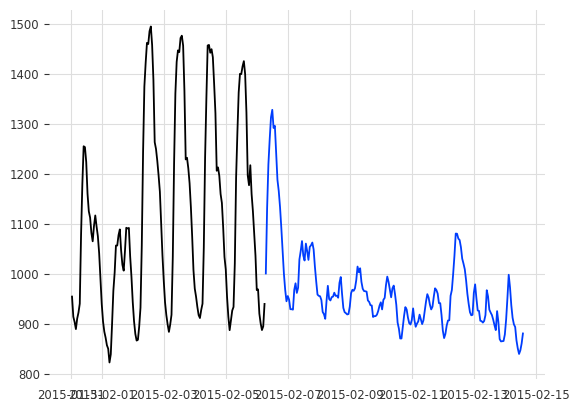

In [72]:
# sorted_train=my_series_train.sort_index()
# print(sorted_train)

sorted_pred= pred_dict['median'].sort_index()
plt.plot(sorted_train)
plt.plot(sorted_pred)

In [19]:
print(sorted_test.head(5))
print(sorted_pred.head(5))
print(len(sorted_pred), len(sorted_test))

2015-02-04 15:00:00    1380.0214
2015-02-04 16:00:00    1321.5847
2015-02-04 17:00:00    1206.1117
2015-02-04 18:00:00    1212.8491
2015-02-04 19:00:00    1196.0489
Name: 0, dtype: float64
2015-02-04 15:00:00     988.020295
2015-02-04 16:00:00    1155.473276
2015-02-04 17:00:00    1280.466670
2015-02-04 18:00:00    1366.339993
2015-02-04 19:00:00    1406.891285
dtype: float64
40 40


In [73]:
def get_mae(test, pred, title):
    sum_test = test.sum()
    abs_diff = abs(test - pred)    
    mape = (abs_diff/sum_test).sum()
    print(f"Results for {title}")
    return round(mape,3)
get_mae(sorted_test, sorted_pred, "gpt-4-pred")

Results for gpt-4-pred


0.151

<h2>pichle saal ka same time ka zyada data train me bhejdo , and then next year ka same time ka data test/pred me bhej do</h2>

In [20]:
pred_dict['median']

2017-10-02 06:00:00    1119.915095
2015-06-19 02:00:00    1146.491153
2015-12-02 17:00:00    1344.748547
2019-03-08 06:00:00    1172.535690
2015-12-04 08:00:00    1183.166113
2016-12-30 17:00:00    1019.457594
2019-04-09 03:00:00    1170.941126
2018-04-13 03:00:00    1192.733494
2018-09-03 06:00:00    1110.879235
2019-03-27 20:00:00    1178.913944
2015-04-09 09:00:00    1283.092092
2015-03-10 00:00:00    1226.219328
2017-04-23 15:00:00    1169.878084
2017-08-30 11:00:00    1324.019222
2018-05-10 16:00:00    1307.542066
2018-06-17 06:00:00    1183.166113
2015-12-06 23:00:00    1161.905267
2015-03-10 15:00:00    1274.587754
2018-11-12 00:00:00    1157.121576
2015-12-01 11:00:00    1120.446616
2018-01-11 21:00:00    1210.273693
2015-04-24 02:00:00    1224.093243
2015-06-07 20:00:00    1185.823719
2019-01-04 14:00:00    1317.109447
2017-03-27 04:00:00    1166.157436
2017-08-15 07:00:00    1212.931299
2017-12-10 08:00:00    1084.834698
2017-01-06 06:00:00    1223.030201
2017-01-10 17:00:00 